In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
sys.path.append('/Users/koush/Projects/scLDL/src')

import scanpy as sc
import numpy as np
import pandas as pd
import torch
import anndata
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from scLDL.models.label_enhancer import LabelEnhancer
from scLDL.models.trainer import LabelEnhancerTrainer
from scLDL.utils.data import scDataset
from scLDL.utils.metrics import compute_metrics

In [3]:
adata = sc.read_h5ad(
    "../data/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [4]:
adata.obs = adata.obs.join(pd.read_csv(
    "/Users/koush/Projects/scLDL/data/tonsil_cell_types.csv").set_index("NAME"))

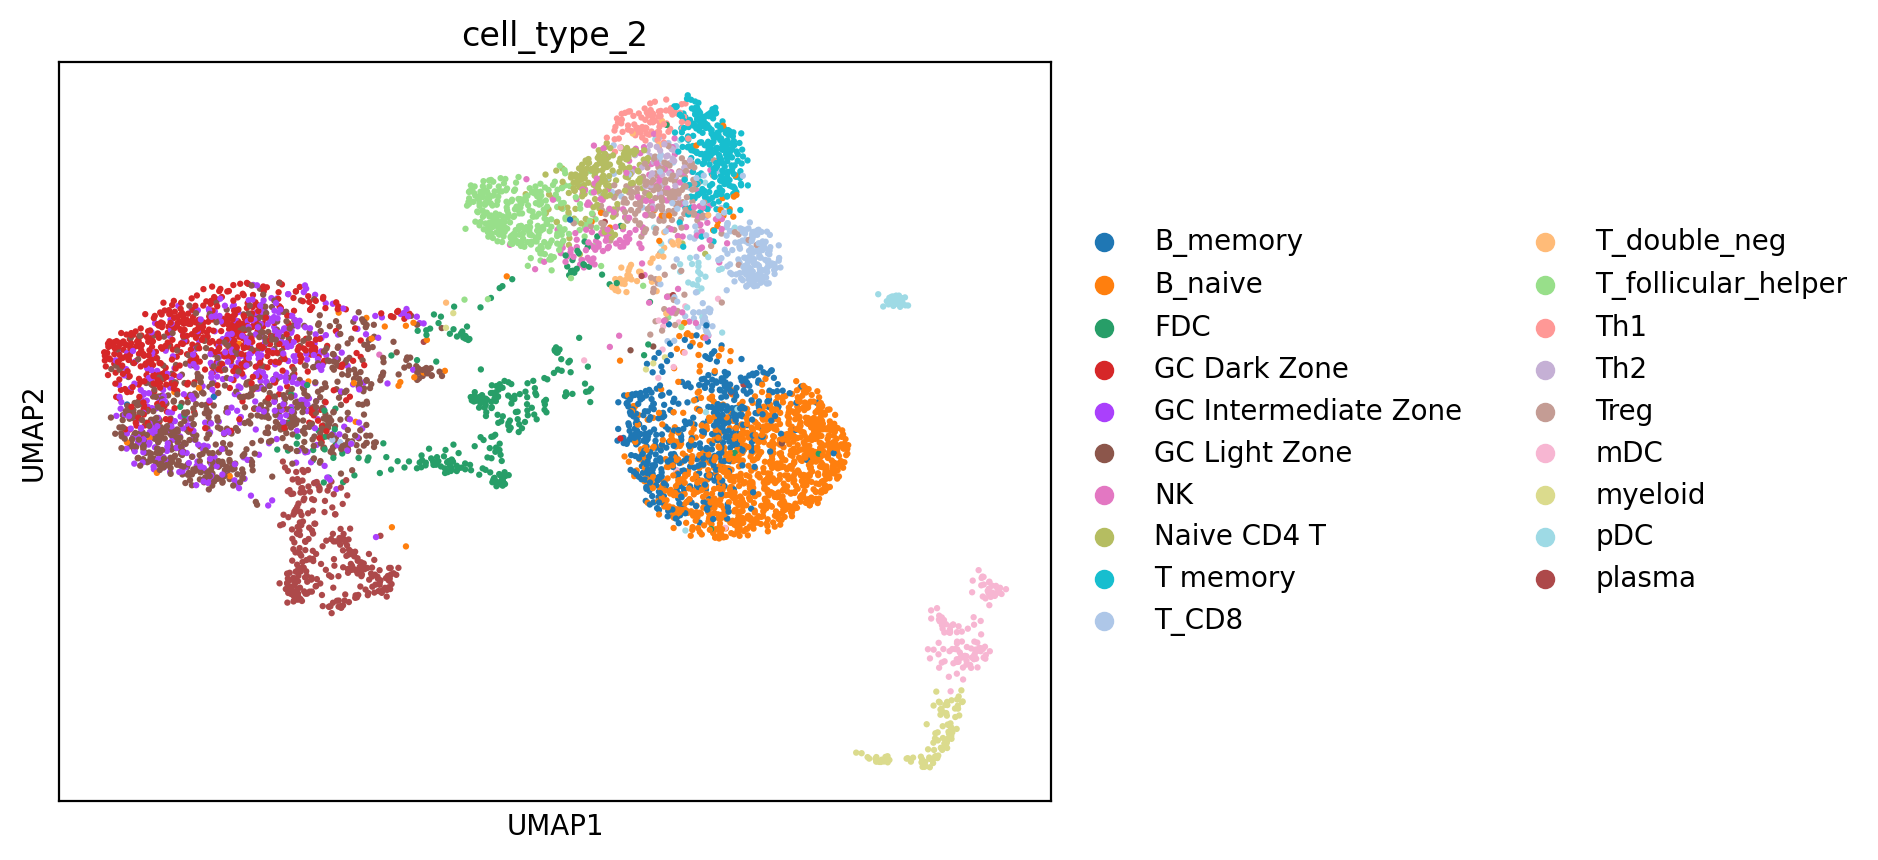

In [5]:
sc.pl.umap(adata, color='cell_type_2')

In [6]:
print("Generating synthetic single-cell data...")
# # 1. Generate synthetic data
# # 1000 cells, 500 genes, 3 cell types
# n_obs = 1000
# n_vars = 500
# n_classes = 3

# X = np.random.randn(n_obs, n_vars).astype(np.float32)
# # Add some signal
# labels = np.random.randint(0, n_classes, n_obs)
# for i in range(n_classes):
#     X[labels == i, :50] += i * 2.0
    
# # Create AnnData
# adata = anndata.AnnData(X=X)
# adata.obs['cell_type'] = labels
# adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

# # Add dummy spatial coordinates
# adata.obsm['spatial'] = np.random.rand(n_obs, 2).astype(np.float32)

# Create Ground Truth Distributions (for testing metrics)
n_obs = adata.shape[0]
n_classes = len(adata.obs['cell_type_2'].unique())
labels = adata.obs['cell_type_2'].cat.codes.values


Generating synthetic single-cell data...


In [7]:
y_true = labels.astype(np.float32)

In [9]:
dataset = scDataset(adata, layer='normalized_count', label_key='cell_type_2', spatial_key='spatial')
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LabelEnhancer(
    x_dim=dataset.get_input_dim(),
    d_dim=dataset.get_num_classes(),
    h_dim=128,
    device=device
)

print("\nStarting Training...")
trainer = LabelEnhancerTrainer(
    model, 
    lr=3e-4, 
    beta=0.001, 
    lambda_gap=1.0, 
    lambda_spatial=0.1
)

trainer.train(train_loader, epochs=500, log_interval=25)


Starting Training...
Starting Pretraining for 50 epochs...
Pretrain Epoch 25: Avg Loss = 0.0729
Pretrain Epoch 50: Avg Loss = 0.0775
Starting Main Training for 500 epochs...
Epoch 25: Avg Loss = -4.1189
Epoch 50: Avg Loss = -3.6665
Epoch 75: Avg Loss = -4.2279
Epoch 100: Avg Loss = -5.2201
Epoch 125: Avg Loss = -4.1301
Epoch 150: Avg Loss = -4.3153
Epoch 175: Avg Loss = -6.2583
Epoch 200: Avg Loss = -6.3214
Epoch 225: Avg Loss = -7.4799
Epoch 250: Avg Loss = -7.1534
Epoch 275: Avg Loss = -7.1033
Epoch 300: Avg Loss = -6.4304
Epoch 325: Avg Loss = -6.6087
Epoch 350: Avg Loss = -7.6787
Epoch 375: Avg Loss = -7.6307
Epoch 400: Avg Loss = 52.4017
Epoch 425: Avg Loss = -7.3879
Epoch 450: Avg Loss = -7.6580
Epoch 475: Avg Loss = -6.2742
Epoch 500: Avg Loss = -7.8320


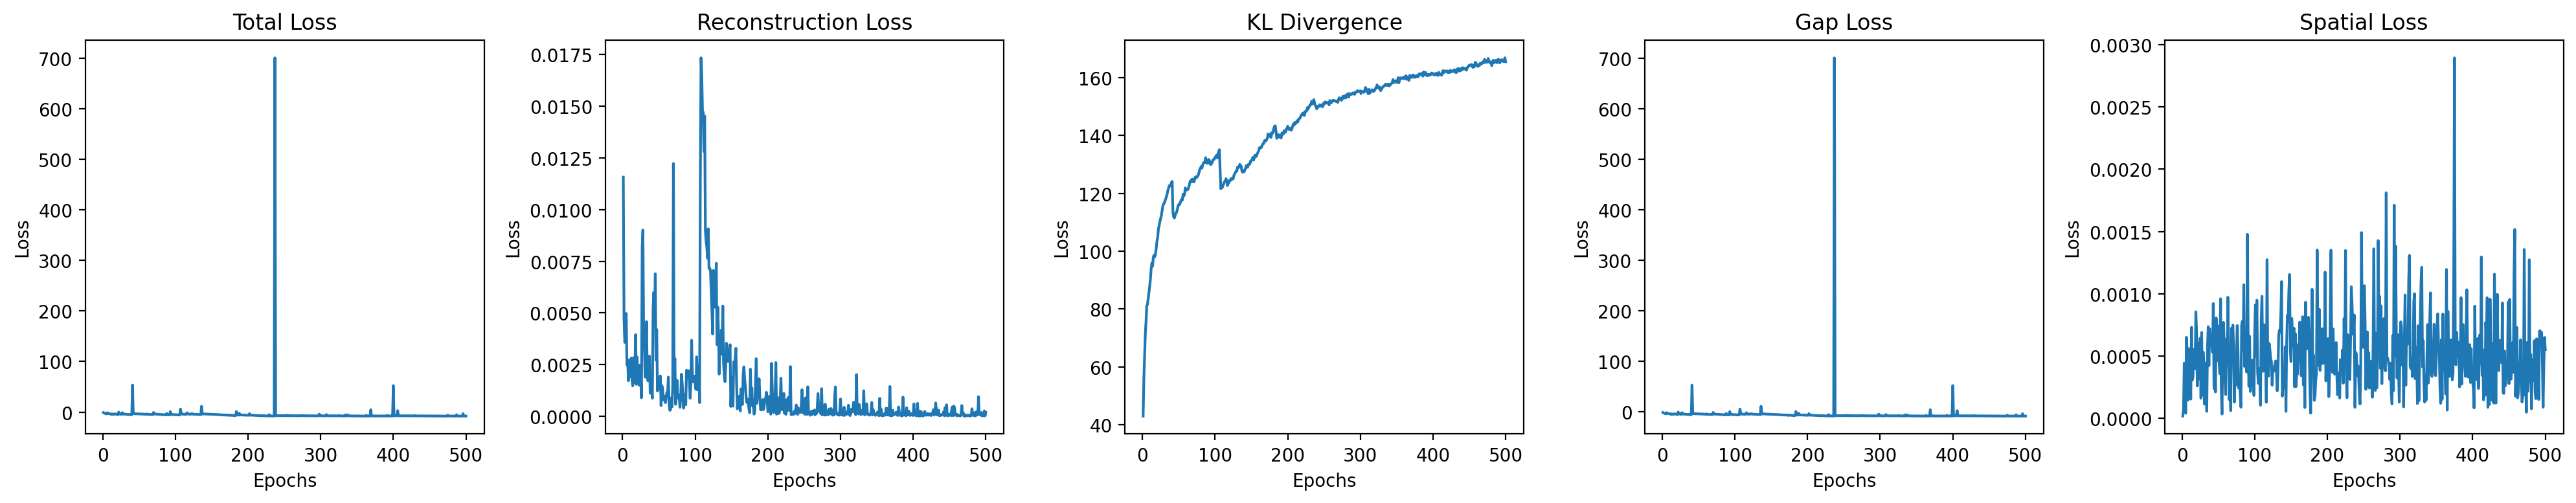

In [20]:
trainer.plot_losses()

In [21]:
# 5. Predict
pred_loader = DataLoader(dataset, batch_size=64, shuffle=False)
distributions = trainer.predict(pred_loader)
adata.obsm['X_label_enhanced'] = distributions
print("\nEvaluating Performance...")
metrics = compute_metrics(y_true, distributions)
print("Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



Evaluating Performance...
Metrics:
Chebyshev ↓: 0.0355
Clark ↓: 0.8798
Canberra ↓: 9.0684
KL Divergence ↓: 0.0699
Cosine Similarity ↑: 0.9872
Intersection Similarity ↑: 0.9645


In [22]:
def encode_labels(labels, reverse_dict=True):
    unique_labels = sorted(list(set(labels)))
    if reverse_dict:
        return {label: i for i, label in enumerate(unique_labels)}
    return {i: label for i, label in enumerate(unique_labels)}

In [23]:
annot = 'cell_type_2'
adata.obs['cell_type_int'] = adata.obs['cell_type_2'].replace(encode_labels(adata.obs['cell_type_2']))

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_88653/2588447620.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs['cell_type_int'] = adata.obs['cell_type_2'].replace(encode_labels(adata.obs['cell_type_2']))
/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_88653/2588447620.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['cell_type_int'] = adata.obs['cell_type_2'].replace(encode_labels(adata.obs['cell_type_2']))


In [24]:
label_dict = encode_labels(adata.obs['cell_type_2'], reverse_dict=False)

In [25]:
label_dict

{0: 'B_memory',
 1: 'B_naive',
 2: 'FDC',
 3: 'GC Dark Zone',
 4: 'GC Intermediate Zone',
 5: 'GC Light Zone',
 6: 'NK',
 7: 'Naive CD4 T',
 8: 'T memory',
 9: 'T_CD8',
 10: 'T_double_neg',
 11: 'T_follicular_helper',
 12: 'Th1',
 13: 'Th2',
 14: 'Treg',
 15: 'mDC',
 16: 'myeloid',
 17: 'pDC',
 18: 'plasma'}

In [31]:
def plot_examples_by_cell_type(adata, n_examples=5, annot='cell_type'):
    if annot in adata.obs:
        unique_cell_types = adata.obs[annot].unique()
        label_col = annot
    else:
        unique_cell_types = adata.obs['cell_type_int'].unique()
        label_col = 'cell_type_int'
        
    n_classes = len(unique_cell_types)

    # Create subplots: rows = cell types, cols = examples
    fig, axes = plt.subplots(n_classes, n_examples, figsize=(3 * n_examples, 2 * n_classes), dpi=120)
    
    # Ensure axes is always 2D for consistent indexing
    axes = np.array(axes).reshape(n_classes, n_examples)

    for i, cell_type in enumerate(unique_cell_types):
        # Find indices for this cell type
        type_indices = np.where(adata.obs[label_col] == cell_type)[0]
        
        # Select random examples
        if len(type_indices) >= n_examples:
            selected_indices = np.random.choice(type_indices, n_examples, replace=False)
        else:
            # Handle case with fewer cells than examples by replacement
            selected_indices = np.random.choice(type_indices, n_examples, replace=True)
            
        for j, idx in enumerate(selected_indices):
            ax = axes[i, j]
            
            # Plot the data if available
            if 'X_label_enhanced' in adata.obsm:
                # Assuming X_label_enhanced[idx] is 1D or 2D array compatible with plot.bar
                data = pd.DataFrame(adata.obsm['X_label_enhanced'][idx])
                data.plot.bar(ax=ax, legend=False, alpha=1)
            
            # Set row label on the first column only
            if j == 0:
                ax.set_ylabel(str(cell_type), rotation=0, labelpad=40, fontsize=10, fontweight='bold', va='center', ha='right')
            
            ax.set_title(f"Idx: {idx}", fontsize=8)
            ax.set_xticks([]) # Hide x-ticks
            ax.set_yticks([]) # Hide y-ticks for cleaner look
            
            # Remove spines for cleaner look
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Usage:
# plot_examples_by_cell_type(adata)

In [32]:
plot_examples_by_cell_type(adata, n_examples=10, annot='cell_type_2')

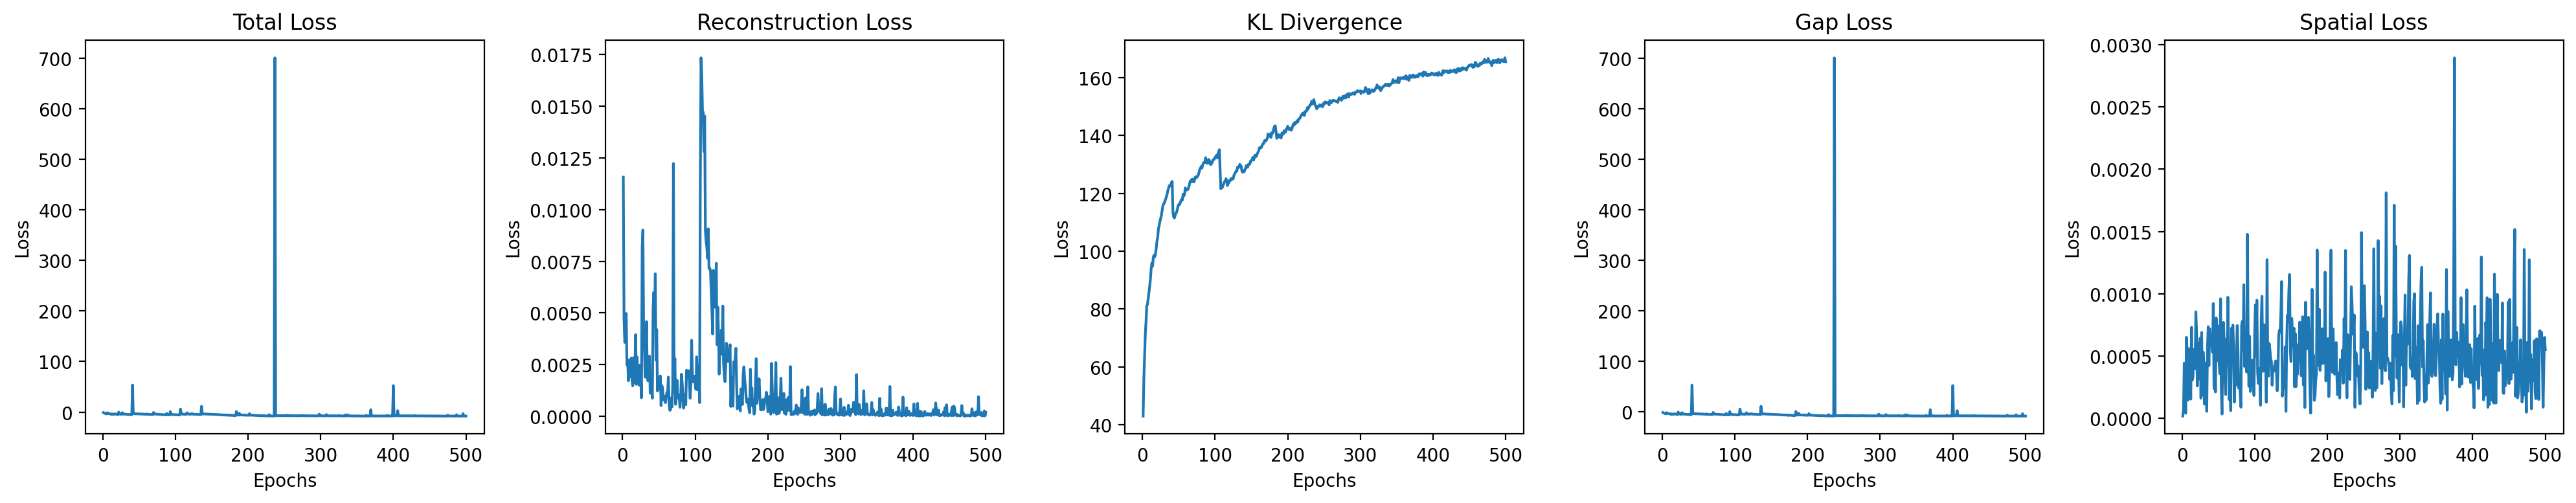

In [33]:
trainer.plot_losses()

In [34]:
adata.obs = adata.obs.join(
    pd.DataFrame(adata.obsm['X_label_enhanced'], 
    index=adata.obs_names, 
    columns=[v for k, v in label_dict.items()])
)

In [35]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['figure.dpi'] = 200
sc.pl.umap(adata, color=[v for k, v in label_dict.items()], frameon=False, cmap='Reds')